### BNC Challenge 2008 課題の前後でのチャンネル同士のコネクティビティの変化
[Development of Global Cortical Networks in Early Infancy](http://www.jneurosci.org/content/30/14/4877)を参考に

検定の流れは
+ １人の被験者につき代表値を462(22ch×21ch)個（タスク別に）算出
+ 横軸にイベント、縦軸にzスコアをとり９人それぞれの点をプロット
+ この図についてt検定
+ p値ではなくFDRを考慮したq値で優位差を判断

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.signal import correlate
from scipy.stats import zscore, norm, ttest_rel
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(style="whitegrid", color_codes=True)
import mne
from mne.connectivity import spectral_connectivity
import itertools

In [2]:
event_id = dict(left_hand=1, right_hand=2, feet=3, tongue=4)  # event ID

In [3]:
fs = 250 # Sampling frequency
info = mne.create_info(["ch"+str(i) for i in range(25)], fs) #  Channel labels and sampling freq.

In [125]:
# Read events from csv
#subjects = ['A01T', 'A02T', 'A03T', 'A04T', 'A05T', 'A06T', 'A07T', 'A08T', 'A09T']
subjects = ['A01T', 'A02T', 'A03T']
#subjects = ['A01T']
#events = [0] * len(subjects)
#eegs = [0] * len(subjects)
#raw = [0] * len(subjects)
epochs = [0] * len(subjects)
#cm_post = [0] * len(subjects)
#cm_binary = [0] * len(subjects)
#one_cm = [0] * len(subjects)
#cm_pre = [0] * len(subjects)
#cm_pre_binary = [0] * len(subjects)

In [126]:
for (i, subject) in enumerate(subjects):
    events = pd.read_csv('./datasets/events_'+subject+'.csv', header=None)
    events = np.array(events.astype(int))
    eegs = pd.read_csv('./datasets/eeg_'+subject+'.csv', header=None)
    raw = mne.io.array.RawArray(eegs, info)
    epochs[i] = mne.Epochs(raw, events, event_id, tmin=0.0, tmax=6.0, baseline=(None,0), preload=True, add_eeg_ref=False)

Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading data for 336 events and 1501 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading data for 336 events and 1501 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading data for 336 events and 1501 original time points ...
0 bad epochs dropped


imagery coherenceの計算

In [ ]:
# Compute connectivity for band containing the evoked response.
# We exclude the baseline period
fmin, fmax = 14., 30.
sfreq = raw.info['sfreq']  # the sampling frequency
tmin = 3.0  # exclude the baseline period
tmax = 5.0
connections = []
for k in range(len(subjects)):
    for i in range(len(epochs[k])):
        con, freqs, times, n_epochs, n_tapers = spectral_connectivity(epochs[k][i], method='imcoh', mode='multitaper', sfreq=sfreq, fmin=fmin, fmax=fmax,
        faverage=True, tmin=tmin, tmax=tmax, mt_adaptive=False, n_jobs=1)
        connections.append(con)

Connectivity computation...
    computing connectivity for 300 connections
    using t=3.000s..5.000s for estimation (501 points)
    frequencies: 14.5Hz..29.9Hz (32 points)
    connectivity scores will be averaged for each band
    using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Imaginary Coherence
    computing connectivity for epoch 1
    assembling connectivity matrix
[Connectivity computation done]
Connectivity computation...
    computing connectivity for 300 connections
    using t=3.000s..5.000s for estimation (501 points)
    frequencies: 14.5Hz..29.9Hz (32 points)
    connectivity scores will be averaged for each band
    using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Imaginary Coherence
    computing connectivity for epoch 1
    assembling connectivity matrix
[Connectivity computation done]
Connectivity computation...
    computing connectivity for 300 connections
    u

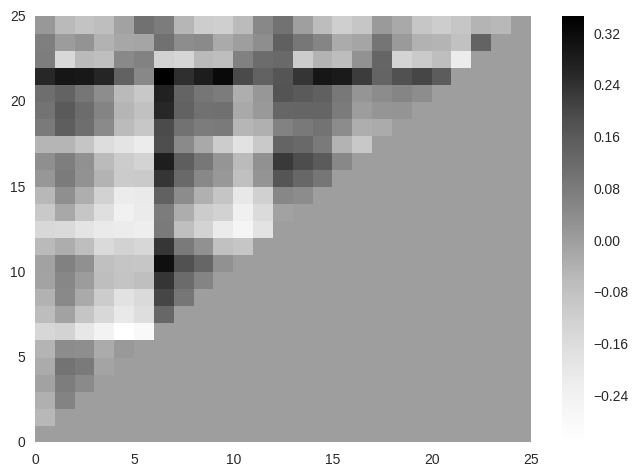

In [167]:
plt.pcolor(connections[60][:,:,0] - connections[61][:,:,0])
plt.colorbar()

### 分類器の作成

In [156]:
# 教師データ
y_train = []
for epoch in epochs:
    y_train = y_train + list(epoch.events[:,2])
len(y_train)

1008

In [157]:
# 学習データ
X_train = []
for i in range(len(connections)):
    con_vec = connections[i][:22,:22,0].reshape(1,-1)[0]
    con_vec = con_vec[con_vec != 0]
    con_normed = (con_vec - con_vec.mean())/con_vec.std()
    X_train.append(con_normed)
len(X_train[0])

231

In [158]:
from sklearn import svm
clf = svm.SVC(C=20, cache_size=200, class_weight="balanced", \
                          gamma="auto", kernel="rbf", \
                          max_iter=-1, probability=False,random_state=None, \
                          shrinking=True, tol=0.001, verbose=False, decision_function_shape='ovr')

In [166]:
from sklearn import cross_validation
Xc_train, Xc_test, yc_train, yc_test = cross_validation.train_test_split(X_train, y_train, test_size=0.4, random_state=None)
clf.fit(Xc_train, yc_train)
print(clf.score(Xc_test, yc_test))

0.418316831683


テスト用データの読み込み

In [29]:
subjects = ['A01E', 'A02E', 'A03E', 'A04E', 'A05E', 'A06E', 'A07E', 'A08E', 'A09E']
epochs_test = [0] * len(subjects)
for (i, subject) in enumerate(subjects):
    events = pd.read_csv('./datasets/events_'+subject+'.csv', header=None)
    events = np.array(events.astype(int))
    eegs = pd.read_csv('./datasets/eeg_'+subject+'.csv', header=None)
    raw = mne.io.array.RawArray(eegs, info)
    epochs_test[i] = mne.Epochs(raw, events, event_id, tmin=0.0, tmax=6.0, baseline=(None,0), preload=True, add_eeg_ref=False)

Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading data for 336 events and 1501 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading data for 336 events and 1501 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading data for 336 events and 1501 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading

In [ ]:
# Compute connectivity for band containing the evoked response.
# We exclude the baseline period
fmin, fmax = 14., 30.
sfreq = raw.info['sfreq']  # the sampling frequency
tmin = 3.0  # exclude the baseline period
tmax = 5.0
connections_test = []
for k in range(len(subjects)):
    for i in range(len(epochs_test[k])):
        con, freqs, times, n_epochs, n_tapers = spectral_connectivity(epochs_test[k][i], method='imcoh', mode='multitaper', sfreq=sfreq, fmin=fmin, fmax=fmax,
        faverage=True, tmin=tmin, tmax=tmax, mt_adaptive=False, n_jobs=1)
        connections_test.append(con)

In [39]:
# 教師データ
y_test = []
for epoch in epochs_test:
    y_test = y_test + list(epoch.events[:,2])
len(y_test)

3024

In [40]:
# 学習データ
X_test = []
for i in range(len(connections_test)):
    con_vec = connections_test[i][:22,:22,0].reshape(1,-1)[0]
    con_vec = con_vec[con_vec != 0]
    con_normed = (con_vec - con_vec.mean())/con_vec.ptp()
    X_test.append(con_normed)
len(X_test)

3024

In [41]:
clf.score(X_test, y_test)

0.3568121693121693